In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Correlator:
    
    def __init__(self):
        self.image = None
        self.filter = None

    def __padding(self, horizontal_padding, vertical_padding):
        padded_image = np.zeros((self.image.shape[0] + 2 * vertical_padding, self.image.shape[1] + 2 * horizontal_padding, 3))
        
        if vertical_padding == 0:
            padded_image[:, horizontal_padding : -horizontal_padding, :] = self.image 
        elif horizontal_padding == 0:
            padded_image[vertical_padding : -vertical_padding, :, :] = self.image 
        else:
            padded_image[vertical_padding : -vertical_padding, horizontal_padding : -horizontal_padding, :] = self.image 
    
        return padded_image
        
    def apply_correlation(self, image_path, filter_matrix, zero_padding = True):
        self.image = np.array(Image.open(image_path).convert('RGB'))
        self.filter = filter_matrix
        
        vertical_padding = self.filter.shape[0]//2
        horizontal_padding = self.filter.shape[1]//2
        
        if not horizontal_padding and not vertical_padding:
            print("Could not execute padding due to filter shape. Try a Bi dimensional kernel.")
            zero_padding = False
        
        if zero_padding:
            preprocessed_img = self.__padding(horizontal_padding, vertical_padding)
            output = np.zeros((self.image.shape[0], self.image.shape[1], 3))
        else:
            preprocessed_img = self.image
            output = np.zeros((self.image.shape[0] - 2 * vertical_padding, self.image.shape[1] - 2 * horizontal_padding, 3))
    
        for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
            for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                for k in range(3):
                    output[i,j,k] = np.sum(np.multiply(self.filter, preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]))
        
        output[output < 0] = 0
        output[output > 255] = 255
        
        return self.image, preprocessed_img, output
    
    def apply_norm_correlation(self, image_path, filter_matrix, zero_padding = True):
        self.image = np.array(Image.open(image_path).convert('RGB'))
        self.filter = filter_matrix

        epsilon = 1e-7
        
        vertical_padding = self.filter.shape[0]//2
        horizontal_padding = self.filter.shape[1]//2
        
        if not horizontal_padding and not vertical_padding:
            print("Could not execute padding due to filter shape. Try a Bi dimensional kernel.")
            zero_padding = False
        
        if zero_padding:
            preprocessed_img = self.__padding(horizontal_padding, vertical_padding)
            output = np.zeros((self.image.shape[0], self.image.shape[1], 3))
        else:
            preprocessed_img = self.image
            output = np.zeros((self.image.shape[0] - 2 * vertical_padding, self.image.shape[1] - 2 * horizontal_padding, 3))
    

        filter_diff = self.filter - np.mean(self.filter)
        print(filter_diff.shape)
        normalized_filter = filter_diff/np.sum(np.abs(filter_diff + epsilon))
        
        if np.argmax(normalized_filter) == 0:
            print("Warning : Filter has mean zero. Normalization will result in a black image.")

        for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
            for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                for k in range(3):
                    window = preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]
                    window_diff = window - np.mean(window)
                    output[i,j,k] += np.sum(np.multiply((window_diff)/np.sum(np.abs(window_diff + epsilon)), normalized_filter))
                
        output = (output - np.min(output))/(np.max(output) - np.min(output))
        
        return self.image, preprocessed_img, output

    def apply_sobel_filter(self, image_path, zero_padding=True, mode="vertical"):
        if mode == "vertical":
            sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]])
        elif mode == "horizontal":
            sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]]).T
        else:
            print("Choose either vertical or Horizontal")
            return -1
        
        return self.apply_correlation(image_path, sobel_filter, zero_padding=zero_padding)
    
    def apply_box_filter(self, image_path, box_shape=(3,3), zero_padding=True):
        divisor = box_shape[0] * box_shape[1]
        return self.apply_correlation(image_path, np.ones((box_shape[0],box_shape[1]))/divisor, zero_padding)
    
    def apply_median_filter(self, image_path, filter_shape=(3,3), zero_padding=True):
        self.image = np.array(Image.open(image_path).convert('RGB'))

        vertical_padding = filter_shape[0]//2
        horizontal_padding = filter_shape[1]//2

        if not horizontal_padding and not vertical_padding:
            print("Could not execute padding due to filter shape. Try a Bi dimensional kernel.")
            zero_padding = False

        if zero_padding:
            preprocessed_img = self.__padding(horizontal_padding, vertical_padding)
            output = np.zeros((self.image.shape[0], self.image.shape[1], 3))
        else:
            preprocessed_img = self.image
            output = np.zeros((self.image.shape[0] - 2 * vertical_padding, self.image.shape[1] - 2 * horizontal_padding, 3))

        for i in range(preprocessed_img.shape[0] - filter_shape[0]):
            for j in range(preprocessed_img.shape[1] - filter_shape[1]):
                for k in range(3):
                    output[i,j,k] = np.median(preprocessed_img[i: i + filter_shape[0], j: j + filter_shape[1], k])
        
        return self.image, preprocessed_img, output

## 3. Aplicando Sobel na horizontal

In [8]:
c = Correlator()

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", mode="horizontal")

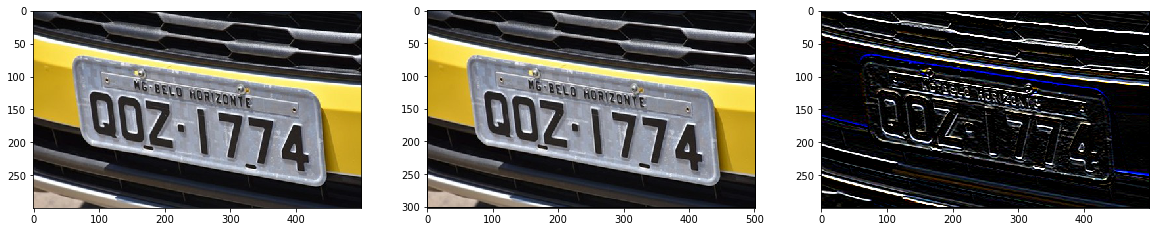

In [9]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

In [10]:
c = Correlator()

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/einstein.png", mode="vertical")

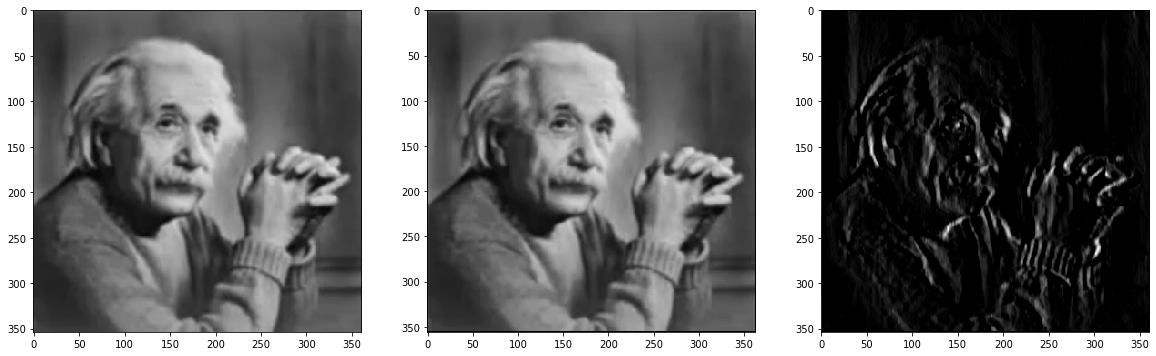

In [11]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

In [108]:
c = Correlator()

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/einstein.png", mode="horizontal")

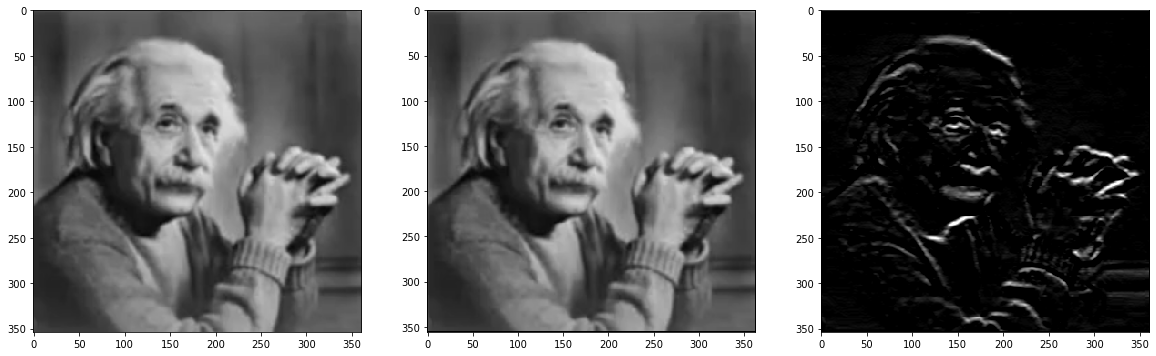

In [109]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## 4.1 Box 25,25

In [14]:
c = Correlator()

filter_matrix = np.ones((25,25))/625

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_matrix)

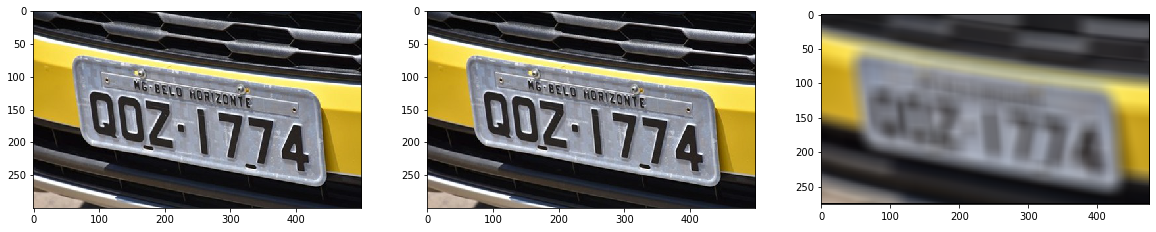

In [13]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

In [112]:
c = Correlator()

original, padded_image, output = c.apply_box_filter("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", box_shape=(25,25))

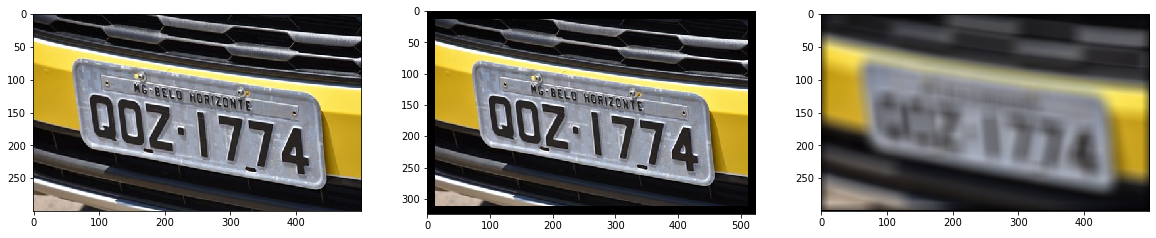

In [113]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## 4.2 Box 25,1

In [114]:
c = Correlator()

filter_matrix = np.ones((25,1))/25

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_matrix)

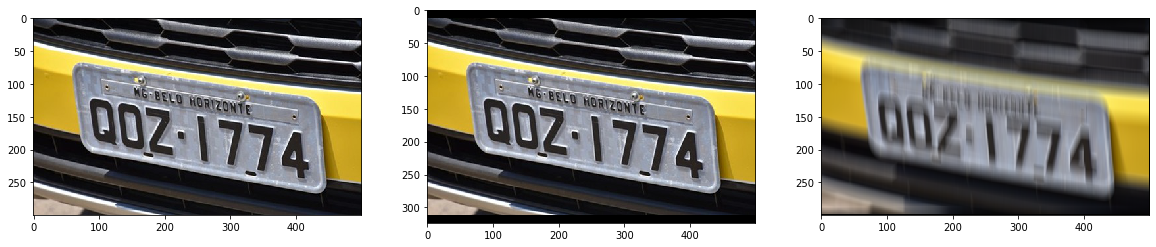

In [115]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## 4.3 Box 1,25

In [116]:
c = Correlator()

filter_matrix = np.ones((1,25))/25

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_matrix)

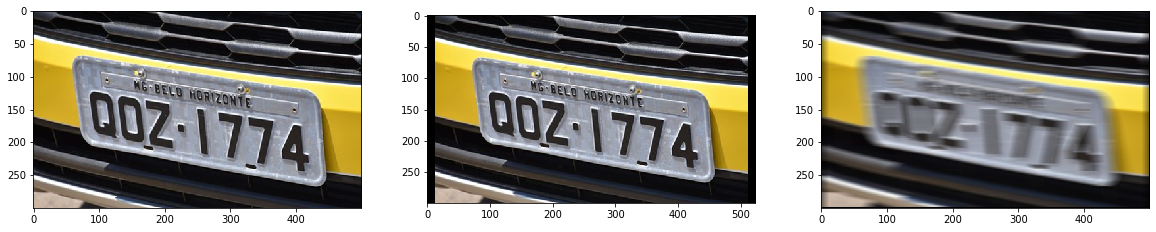

In [117]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## Filtro mediana

In [118]:
c = Correlator()

original, padded_image, output = c.apply_median_filter("../app/assets/Imagens_teste/Detran_Minas-Gerais.jpg", filter_shape=(20,20))

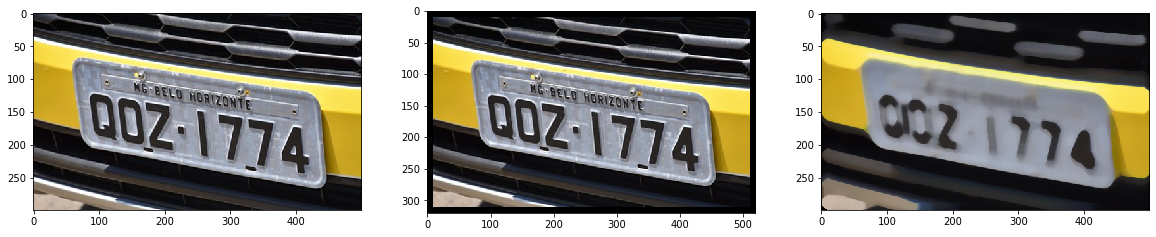

In [119]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## fILTROS AVULSOFHJFDJAFÁF

In [120]:
c = Correlator()

filter_matrix = np.array([[-1,-1,-1],
                         [-1,8.12,-1],
                         [-1,-1,-1]])

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/oi.png", filter_matrix)

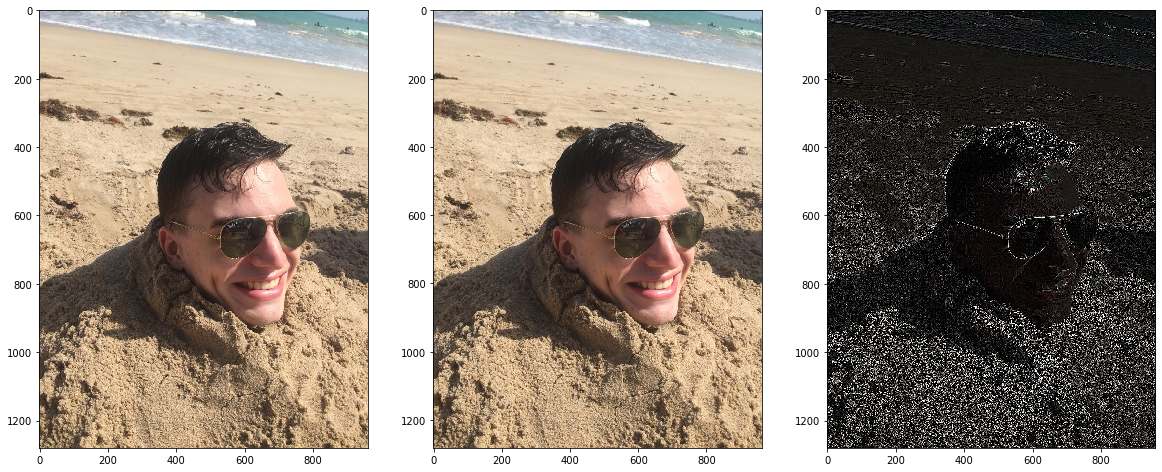

In [121]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()

## Correlação feita

In [261]:
c = Correlator()

filter_matrix = np.array(Image.open("../app/assets/Imagens_teste/einstein.png").convert('RGB'))

In [262]:
filter_matrix = imagem_einstein[100:180,120:200,1]

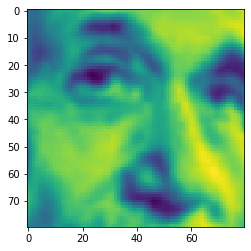

In [263]:
plt.imshow(filter_matrix)

In [264]:
original, padded_image, output = c.apply_norm_correlation("../app/assets/Imagens_teste/einstein.png", filter_matrix, zero_padding=True)

(80, 80)


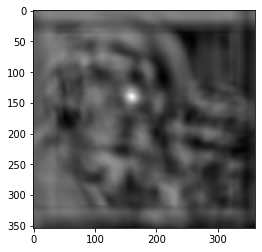

In [265]:
plt.imshow(output.astype(float))
plt.show()

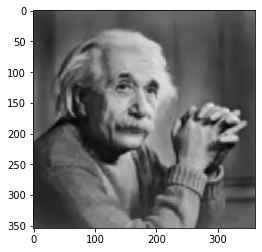

In [266]:
plt.imshow(original.astype(int))
plt.show()